## Imports 

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
from pprint import pprint
import random
import seaborn as sns
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
import math
from tensorflow.keras.models import Model

img_size = 124

## Directories having data
"metadata_directory" - Contains data about the images including file name, bounding box coordinates, class name (Masked or Non Masked) to name a few
"image_directory" - Contains the actual images

In [2]:
metadata_directory = "C:/Users/abhis/jupyter/Untitled Folder/data/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "C:/Users/abhis/jupyter/Untitled Folder/data/Medical Mask/Medical Mask/Medical Mask/images"


In [3]:
def bounding_box(i, j):
    x,y,w,h = j["BoundingBox"]
    img = cv2.imread(os.path.join(image_directory,i),1)
    img = img[y:h,x:w]
    img = cv2.resize(img,(img_size,img_size))
    return img

## Dispaying JSON structure of metadata 

In [4]:
mask_class = []
data = []

def getJSON(filepath):
    with open(filepath) as f:
        return json.loads(f.read())

filenames = os.listdir(metadata_directory)
jsonfiles = [os.path.join(metadata_directory, filename) for filename in filenames]
jsondata = []
for jsonfile in jsonfiles:
    attr = getJSON(jsonfile)
    for i in attr["Annotations"]:
        if i["classname"] == 'face_no_mask':
            mask_class.append("No Mask")
            data.append([bounding_box(attr["FileName"], i), 1])
        elif i["classname"] == 'face_with_mask':
            mask_class.append("Mask")
            data.append([bounding_box(attr["FileName"], i), 0])
    jsondata.append(attr)
pprint(jsondata[0])
random.shuffle(data)

{'Annotations': [{'Attributes': {},
                  'BoundingBox': [451, 186, 895, 697],
                  'Confidence': 1,
                  'ID': 924868908868875136,
                  'classname': 'face_no_mask',
                  'isProtected': False}],
 'FileName': '1801.jpg',
 'NumOfAnno': 1}


## Metadata in csv format

In [5]:
df = pd.read_csv("C:/Users/abhis/jupyter/Untitled Folder/data/train.csv")
df.head

<bound method NDFrame.head of            name   x1   x2   y1   y2       classname
0      2756.png   69  126  294  392  face_with_mask
1      2756.png  505   10  723  283  face_with_mask
2      2756.png   75  252  264  390   mask_colorful
3      2756.png  521  136  711  277   mask_colorful
4      6098.jpg  360   85  728  653    face_no_mask
...         ...  ...  ...  ...  ...             ...
15407  1894.jpg  437  121  907  644  face_with_mask
15408  1894.jpg  557  363  876  636   mask_surgical
15409  1894.jpg  411    3  940  325             hat
15410  3216.png  126   69  409  463  face_with_mask
15411  3216.png  136  289  393  461   mask_colorful

[15412 rows x 6 columns]>

## Plot of the amount of data available into two different classes - Masked and Non Masked

Counter({'Mask': 4180, 'No Mask': 1569})


C:\Users\abhis\anaconda3\envs\tensorflow-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

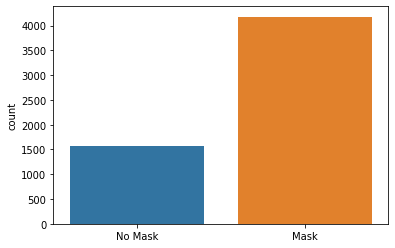

In [6]:
pprint(Counter(mask_class))
sns.countplot(mask_class)

## Model Architecture

In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 dropout (Dropout)           (None, 460800)            0         
                                                        

## Model configuration to start training
Defined parameters - loss function, optimizer and the metrics to be evaluated during training and testing

In [8]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001) ,metrics=['accuracy'])

In [9]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)
    
print("Shape of X -> ", X[0].shape)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

print("Unique elements in Y -> ", np.unique(Y))
print("Shape of Y -> ", Y.shape)

Shape of X ->  (124, 124, 3)
Unique elements in Y ->  [0 1]
Shape of Y ->  (5749,)


## Splitting available data into training and testing dataset. Size of Train data - 70% and Size of Testing data - 20% and Size of Validation data - 10%

In [10]:
xtrain,xtest,ytrain,ytest=train_test_split(X, Y,train_size=0.8,random_state=0)
xtrain,xval,ytrain,yval=train_test_split(xtrain, ytrain,train_size=0.875,random_state=0)

## ImageDataGenerator is used to augment your images. It can standardize, rotate, shift, flip, change brightness, etc of your image.

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [12]:
early_stop = EarlyStopping(monitor='accuracy',patience=4,mode='max')

## Training model with early stopping

In [13]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=16),
                    epochs=50,
                    callbacks=[early_stop],
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50
252/252 [==============================] - 25s 62ms/step - loss: 0.3336 - accuracy: 0.8511 - val_loss: 0.2127 - val_accuracy: 0.9200
Epoch 2/50
252/252 [==============================] - 14s 55ms/step - loss: 0.2545 - accuracy: 0.8887 - val_loss: 0.1813 - val_accuracy: 0.9252
Epoch 3/50
252/252 [==============================] - 14s 54ms/step - loss: 0.2469 - accuracy: 0.8931 - val_loss: 0.1803 - val_accuracy: 0.9339
Epoch 4/50
252/252 [==============================] - 14s 54ms/step - loss: 0.2435 - accuracy: 0.9028 - val_loss: 0.1688 - val_accuracy: 0.9374
Epoch 5/50
252/252 [==============================] - 14s 54ms/step - loss: 0.2357 - accuracy: 0.9003 - val_loss: 0.1773 - val_accuracy: 0.9270
Epoch 6/50
252/252 [==============================] - 14s 54ms/step - loss: 0.2216 - accuracy: 0.9100 - val_loss: 0.1805 - val_accuracy: 0.9322
Epoch 7/50
252/252 [==============================] - 14s 55ms/step - loss: 0.2154 - accuracy: 0.9071 - val_loss: 0.1901 - val_accuracy:

## Results on test dataset 

In [14]:
test_loss,test_accuracy = model.evaluate(xtest, ytest)
print('Test Loss for Model: ',test_loss)
print('Test Accuracy for Model: ',test_accuracy)

36/36 [==============================] - 1s 31ms/step - loss: 0.1663 - accuracy: 0.9409
Test Loss for Model:  0.1662766933441162
Test Accuracy for Model:  0.9408695697784424


## Model Accuracy and Model Loss

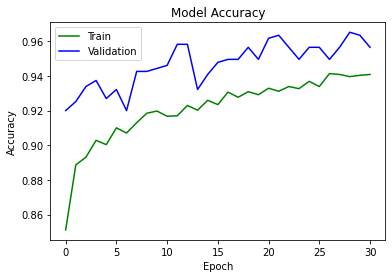

In [25]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

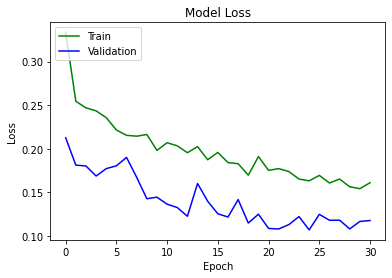

In [26]:

plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Saving model 

In [17]:
model.save("mask_prediction.h5")

## Loading SSD model for Face detection for testing

In [18]:
cvNet = cv2.dnn.readNetFromCaffe('model/architecture.txt','model/weights.caffemodel')

In [19]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [20]:
def processImage(image):
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.15, (36,255,12), 3)
        except:pass
    return image

## predicting faces in dataset

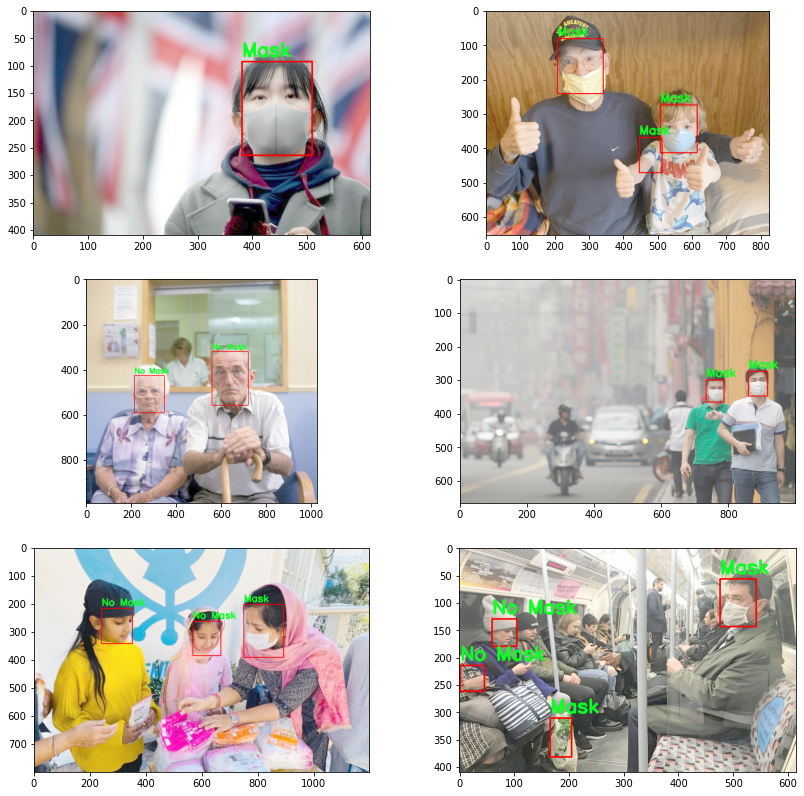

In [21]:

test_images = ['0063.jpg','0321.jpg', '0380.jpg','0122.jpeg','0076.jpg','0065.jpg']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image = processImage(image)
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Features at every convolutional layer


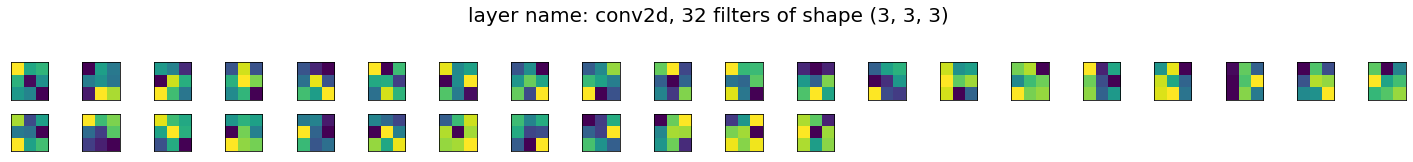

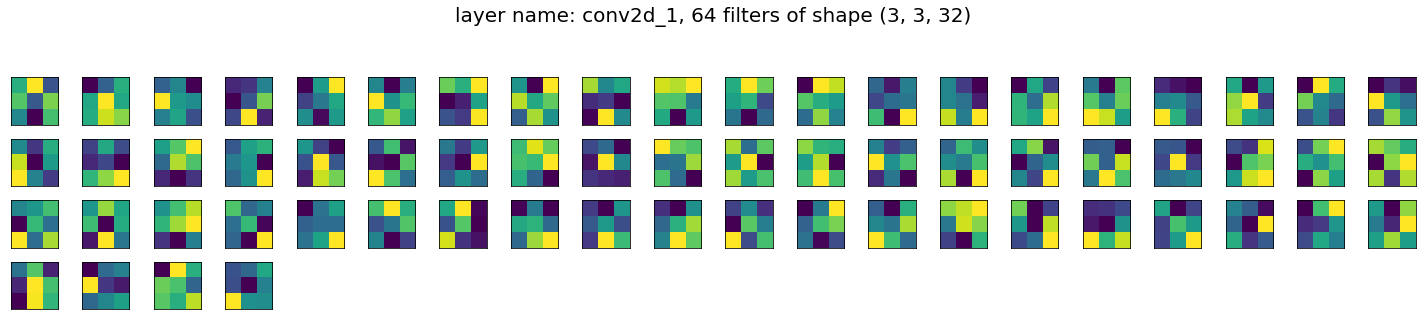

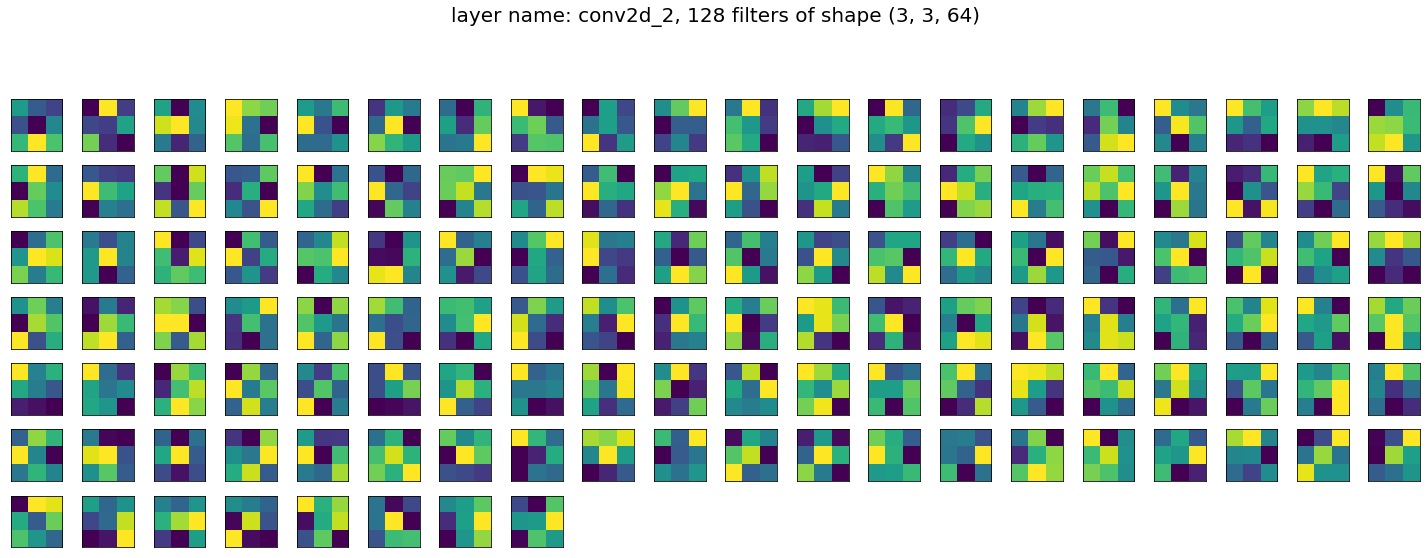

In [22]:

layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

INTERESTED_CONV_LAYERS = ["conv2d", "conv2d_1", "conv2d_2"]

idx = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:        
        layer_output = layer[1].output
        filters, bias = layer[1].get_weights()     
        filters = (filters - filters.min()) / (filters.max() - filters.min())
    
        cols = 20
        rows = math.ceil(filters.shape[-1] / cols)
        fig = plt.figure(idx, (20, rows))

        idx += 1
        for i,f in enumerate(np.rollaxis(filters, 3)):
            ax = plt.subplot(rows, cols, i+1)
            f = np.mean(f, axis=2)
            ax.imshow(f, cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            plt.suptitle(f"layer name: {layer[0]}, {filters.shape[3]} filters of shape {filters.shape[:-1]}", fontsize=20, y=1.1)
            plt.tight_layout()



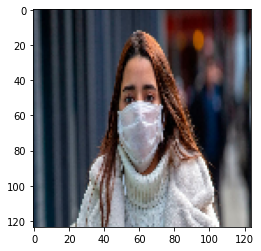

(124, 124, 3)


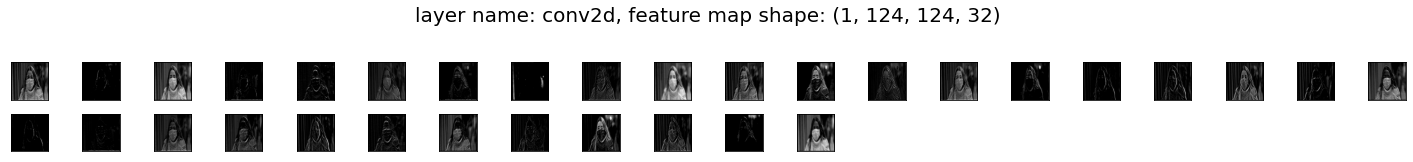

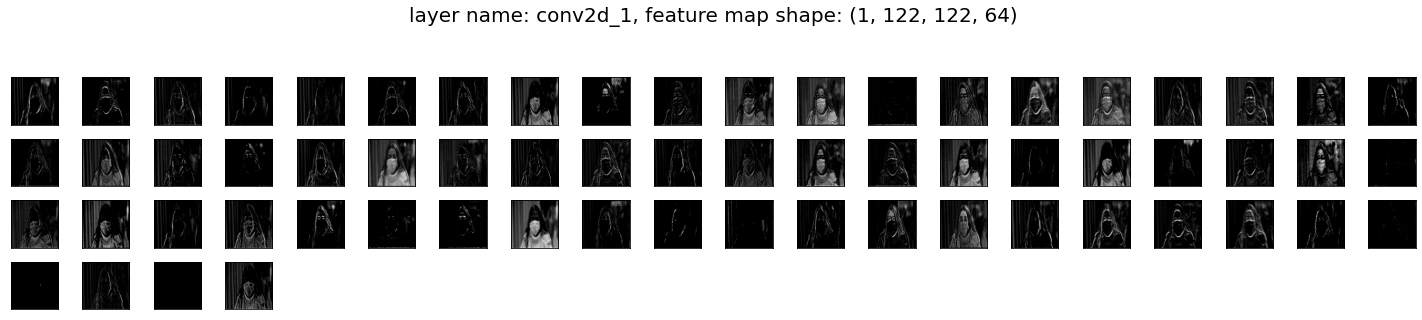

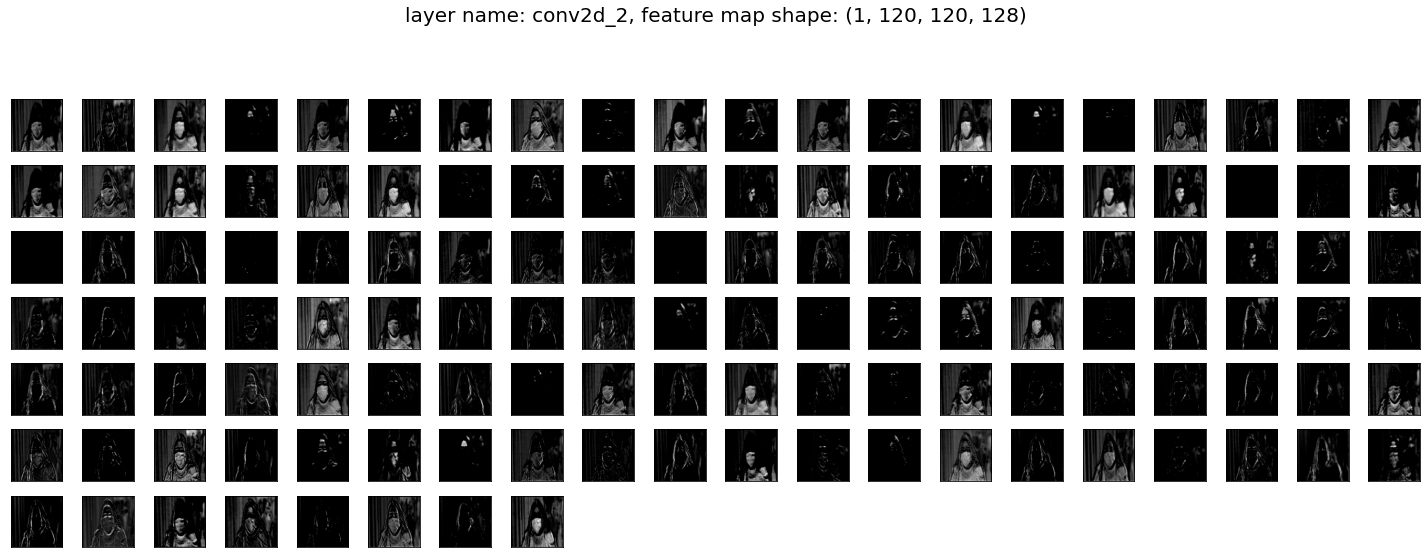

In [23]:

layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]

sample_img = cv2.imread(os.path.join(image_directory,'0055.jpg'))

sample_img = cv2.resize(sample_img,(img_size,img_size))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.show()
# plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
print(sample_img.shape)

sample_img = np.expand_dims(sample_img, axis=0)

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:    
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(sample_img)

        cols = 20
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)
        fig = plt.figure(i, (20, rows))        
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = plt.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            plt.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            plt.tight_layout()